# Úkol č. 1 - vizualizace dat a web scraping (do 11. října)

  * V rámci tohoto úkolu musíte stáhnout dat z webu (tzv. _web scraping_, velmi základní) a následně data zpracovat a vizualizovat.
  * Cílem bude stáhnout data ze serveru https://www.psp.cz/sqw/hlasovani.sqw?o=8 týkající hlasování současné poslanecké sněmovny, uložit tato data v tabulkovém formátu a pak vymyslet vizualizace a zobrazení dat, které umožní orientaci v těchto datech a zvýrazní zajímavé informace a zobrazit přehledně časový vývoj různých veličin.
 
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Data

 * Měli byste stáhnout data ze všech hlasování současné poslanecké sněmovny (tj. od voleb v roce 2017) a to až na úroveň jednotlivých poslanců. 
 * Data by měla obsahovat i stručný popis toho, o jaké hlasování šlo.

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Strojově stáhněte data a uložte je do vhodného formátu, který se Vám bude dále dobře zpracovávat. 
  * **I když nemusíte mít sněmovnu rádi, snažte se nezahltit server a mezi požadavky na stránku mějte alespoň vteřinu mezeru.**
  * V druhé části Vašeho Jupyter notebooku pracujte se staženými daty v souborech, které jsou výsledkem Vašeho stahovacího skriptu (aby opravující nemusel spouštět stahování z webu).
  * S využitím vybraných nástrojů zpracujte data a vymyslete vizualizace a grafy, aby bylo vidět následující:
    * Odchody a přeběhnutí poslanců mezi jednotlivými stranami.
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.
    * Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.
    * Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.).
  * Najděte jednotlivé poslance, kteří se nejvíce shodují při svém hlasování či kteří mají co nejpodobnější účast na hlasování.
  * Zkuste rozlišit v datech důležitá hlasování a zpracujte vizualizace (také) pro ně.
  * Zkuste najít hlasování, kde poslanci hlasovali nejvíce jinak, než obvykle.
  
## Tipy a triky
  * Balíčky iportujte na začátku notebooku (příp. na začátku scrapovací a pak na začátku vizualizační části).
  * Využívejte markdown buňky (jako je ta, ve které je tento text) a naspisy, abyste usnadnily orientaci opravující(mu).
  * Pečlivě si vybírejte grafy a vizualizace, aby co nejlépe vyjádřily to, co vyjádřit chcete. Doporučuji projít si pro inspiraci alespoň galerie balíčků `matplotlib` a `seaborn`.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook (příp. doplněn skripty), ale i soubor(y) se staženými daty (ať opravující nemusí stahovat data).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

## Steps:
1. Think
2. Download data
3. Parse data
4. Visualize
5. ??
6. Profit

## Download Data - nespúštať ak nechcete downloadovať, všetko je v priečinku ../data

In [43]:
import time
import requests
from bs4 import BeautifulSoup
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
import pandas as pd
import os
import html5lib
import matplotlib.pyplot as plt # takto se matplotlib standardně importuje
import matplotlib
import seaborn as sns
# Bez násl. řádku někdy nefunguje vykreslování grafů v Jupyter noteboocích
%matplotlib inline 
URL_PREFIX = 'https://www.psp.cz/sqw/'

#### Linky na jednotlive hlasovania, je ich 61

In [3]:
session = requests.Session()
session.headers.update({
    'User-Agent': 'Mozilla/5.0'
})
retries = Retry(total=5,
                backoff_factor=1,
                status_forcelist=[429, 500, 502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))

url = URL_PREFIX + 'hlasovani.sqw?o=8'
response = session.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table')
meetings = []
for tr in table.findAllNext('tr'):
    try:
        meetings.append(URL_PREFIX + tr.find('td').find('a')['href'])
    except:
        pass

#### Výsledky hlasovania a linky na jednotlive schodzky

In [2]:
def links_from_vote(vote_links, response):
    soup = BeautifulSoup(response.text, 'html.parser')
    starting_point = soup.find('table')
    for link in starting_point.findAllNext('a'):
        if not str(link['href']).startswith('hlasy'):
            continue
        else:
            vote_links[link.text] = link['href']
    return vote_links


In [ ]:
# vysledky hlasovani vsech navrhu vsech hlasovani
all_votings_results = pd.DataFrame
init_dfs_flag = True
# kazda schuzka ma svoj dict vote_links
meetings_vote_links = []
for mtg_url in meetings:
    response = requests.get(mtg_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    vote_log = soup.find(id='main-content')
    table_url = URL_PREFIX + vote_log.find_next('a')['href']
    response = requests.get(table_url)
    # initiate table
    # kluc v dict je cislo navrhu
    vote_links = {}
    if init_dfs_flag:
        all_votings_results = pd.read_html(response.text)[0]
        vote_links = links_from_vote(vote_links, response)

    for i in range(1, 100):
        if init_dfs_flag:
            init_dfs_flag = False
            continue
        page_url = table_url[:len(table_url) - 1] + str(i)
        print(page_url)
        response = requests.get(page_url)
        try:
            all_votings_results = all_votings_results.append(pd.read_html(response.text)[0])
        except:
            break
        vote_links = links_from_vote(vote_links, response)
        print(vote_links)
    meetings_vote_links.append(vote_links)
all_votings_results['Výsledek'] = all_votings_results['Výsledek'].map({'Přijato': 1, "Zamítnuto": 0})
print(all_votings_results)
#print(meetings_vote_links)
#print(vote_links)


#### Vlastná classa, ktorá obsahuje jedno hlasovanie z 61 hlasovanie

In [6]:
class CProposal:
    def __init__(self, meeting_n=None, voting_n=None, url=None, response=None):
        if meeting_n is not None:
            self.meeting_n = meeting_n
            self.voting_n = voting_n
            soup = BeautifulSoup(response.text, 'html.parser')
            results_tag = soup.find_all('ul', class_='results')
            self.overall_df = pd.read_html(response.text)[1]
            self.overall_df.columns = ["Party", 'N. repr.', 'A', 'N', '0', 'Z', 'M']
            self.overall_df = self.overall_df.assign(Meeting=self.meeting_n)
            self.overall_df = self.overall_df.assign(Proposal=self.voting_n)
            self.df = pd.DataFrame(columns=['Name', 'Party', 'Vote', 'Meeting', 'Proposal'])
            for party in results_tag:
                party_name = str(party.previous_sibling.contents[0].next)[:-2]
                for member in party:
                    row = pd.Series(data={'Name': member.contents[2].string, "Party": party_name,
                                          "Vote": member.contents[0].string, 'Meeting': meeting_n,
                                          'Proposal': voting_n})
                    self.df = self.df.append(row, ignore_index=True)

    def load(self, filename):
        uscore_pos = str(filename).find('_')
        dash_pos = str(filename).find('-')
        dot_pos = str(filename).find('.')
        pos = 0
        if dash_pos < 0:
            pos = uscore_pos
        else:
            pos = dash_pos
        self.meeting_n = int(str(filename)[:pos])
        self.voting_n = int(str(filename)[pos + 1:dot_pos])
        uscorefile = str(self.meeting_n) + '_' + str(self.voting_n) + '.csv'
        dashfile = str(self.meeting_n) + '-' + str(self.voting_n) + '.csv'
        ban = ''
        if dash_pos < 0:
            ban = dashfile
        else:
            ban = uscorefile
        self.df = pd.read_csv('../data/' + uscorefile)
        self.overall_df = pd.read_csv('../data/' + dashfile)
        return ban

    def save(self):
        print('Saving: m: ' + str(self.meeting_n) + ' p: ' + str(self.voting_n))
        members_file = '../data/' + str(self.meeting_n) + '_' + str(self.voting_n) + '.csv'
        party_file = '../data/' + str(self.meeting_n) + '-' + str(self.voting_n) + '.csv'
        self.df.to_csv(members_file, index=False)
        self.overall_df.to_csv(party_file, index=False)

#### Uložiť dataframes v csv podobe

In [ ]:
# 61 meetings, each has many proposals - voting_number
meeting_n = 0
results_meetings.to_csv('results', index=False)
unsuccessful_urls = open('../url.txt', 'a')
for meeting in vote_links:
    meeting_n += 1
    if meeting_n < 19:
        continue
    for voting_number in meeting:
        url = URL_PREFIX + meeting[voting_number]
        print(url)
        try:
            response = requests.get(url)
        except:
            # save unsuccessful urls, try later
            unsuccessful_urls.write("\n")
            unsuccessful_urls.write(url)
            continue
        proposal = CProposal(meeting_n, voting_number, url, response)
        proposal.save()


## Load from files

In [94]:
import glob

In [108]:
df = pd.concat(map(pd.read_csv, glob.glob('../data/*_*.csv')))
df_overall = pd.concat(map(pd.read_csv, glob.glob('../data/*-*.csv')))

In [106]:
df.head()

,Name,Party,Vote,Meeting,Proposal
0,Věra Adámková,ANO,0,39,97
1,Andrej Babiš,ANO,0,39,97
2,Andrea Babišová,ANO,M,39,97
3,Ondřej Babka,ANO,Z,39,97
4,Margita Balaštíková,ANO,N,39,97


In [165]:
df_overall.head(10)

,Party,N. repr.,A,N,0,Z,M,Meeting,Proposal
0,ANO,78,0,39,10,12,17,6,22
1,ODS,25,15,0,7,0,3,6,22
2,Piráti,22,19,0,1,0,2,6,22
3,SPD,22,12,0,5,0,5,6,22
4,ČSSD,15,2,0,3,1,9,6,22
5,KSČM,15,4,0,4,6,1,6,22
6,KDU-ČSL,10,0,1,6,1,2,6,22
7,TOP09,7,3,1,3,0,0,6,22
8,STAN,6,1,0,2,1,2,6,22
9,Celkem,200,56,41,41,21,41,6,22


### Prebehnutia v stranach

In [160]:
change = {}
for representative in df['Name'].unique():
    repr = (df[df['Name'] == representative])['Party'].unique().tolist()
    if len(repr) > 1:
        change[representative] = repr
change_df = pd.DataFrame(columns={'Name', 'From', 'To'})
for representative in change:
    match = df[(df['Meeting'] == 1) & (df['Proposal'] == 1) & (df['Name'] == representative)]
    _from = match.Party.iloc[0]
    change[representative].remove(_from)
    _to = change[representative]
    change_df = change_df.append({'Name':representative, "From": _from, "To": _to }, ignore_index=True)

,Name,From,To
0,Tereza Hyťhová,SPD,[Nezařaz]
1,Marian Bojko,SPD,[Nezařaz]
2,Jaroslav Foldyna,ČSSD,"[Nezařaz, SPD]"
3,Václav Klaus,ODS,[Nezařaz]
4,Zuzana Majerová Zahradníková,ODS,[Nezařaz]
5,Ivana Nevludová,SPD,[Nezařaz]
6,Lubomír Volný,SPD,[Nezařaz]


,0
From,
ODS,2
SPD,4
ČSSD,1


<AxesSubplot:xlabel='From'>

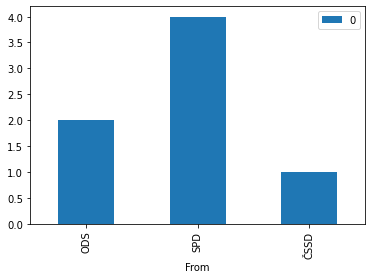

In [163]:
display(change_df)
dd = pd.DataFrame(change_df.groupby('From').size())
display(dd)
dd.plot(kind='bar')

### Dochádzka poslancov

In [166]:
representatives_attendance = {}
total = 0
for representative in df['Name'].unique():
    votings = df.loc[df['Name'] == representative]
    votings = votings.reset_index()
    c = votings.groupby(['Vote']).size()
    representatives_attendance[representative] = c
    total = 0
    for vote in c:
        total += vote
    representatives_attendance[representative]['Total'] = total

KeyboardInterrupt: 

In [ ]:
   
attendance_df = pd.DataFrame(representatives_attendance).T
attendance_df = attendance_df.fillna(0)
attendance_df['Dochádzka'] = (attendance_df['A'] + attendance_df['N'] + attendance_df['Z']) / attendance_df['Total'] * 100
attendance_df = attendance_df.sort_values(by=['Dochádzka'], ascending=False)
plt.figure(figsize=(10,10))
plt.title('Všetci poslanci')
attendance_df['Dochádzka'].plot.bar()
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Najlepšie dochádzky')
attendance_df.head(20)['Dochádzka'].plot.bar()
plt.subplot(222)
plt.title('Najhoršie dochádzky')
attendance_df.tail(20)['Dochádzka'].plot.bar()
print("Najlepšia dochádzka:")
display(attendance_df.head(5))
print('\n')
print("Najhoršia dochádza:")
display(attendance_df.tail(5))

## Dochádzka podľa strán

In [ ]:
party_total = {}
party_att = {}
party_perc = {}
party_data = pd.DataFrame(columns={'Party', "Total", "Attended", 'Percent'})
for party in df_overall.Party.unique():
    total_meeting = 0
    total_attend = 0
    for meeting in df_overall.Meeting.unique():
        for proposal in df_overall[df_overall.Meeting == meeting].Proposal.unique():
            party_att = df_overall[ (df_overall['Party'] == party) & (df_overall['Proposal'] == proposal) 
                              & (df_overall['Meeting'] == meeting)]
            total_meeting += party_att['A'].iloc[0]
            total_meeting += party_att['N'].iloc[0]
            total_meeting += party_att['Z'].iloc[0]
            total_meeting += party_att['M'].iloc[0]
            total_meeting += party_att['0'].iloc[0]
            total_attend += party_att['A'].iloc[0]
            total_attend += party_att['N'].iloc[0]
            total_attend += party_att['Z'].iloc[0]
    party_data = party_data.append({"Party": party, "Total": total_meeting, 'Attended': total_attend, 'Percent': total_attend/total_meeting*100}, ignore_index=True)
display(party_data)

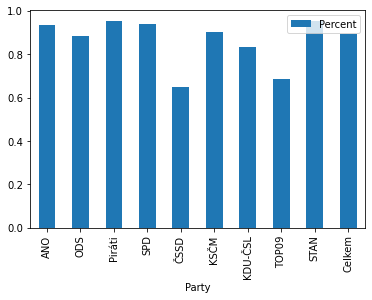

In [54]:
party_data.plot(x='Party', y='Percent', kind='bar')
plt.show()

### Zhoda v hlasovani medzi stranami

In [ ]:
for party in party_data.Party:
    print(party)